In [1]:
import pandas as pd
import numpy as np
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from scipy import interpolate


In [2]:
def get_vlos(file, r_p, omega, level):
    colnames = ['lat', 'lon', 'level', 'alt', 'pres', 'temp',
                            'u', 'v', 'w',
                            'aero_sw_tau_1', 'sw_asym_1', 'sw_pi0_1',
                            'aero_sw_tau_2', 'sw_asym_2', 'sw_pi0_2',
                            'aero_sw_tau_3', 'sw_asym_3', 'sw_pi0_3',
                            'aero_sw_tau_4', 'sw_asym_4', 'sw_pi0_4',
                            'incident_frac']
    df = pd.read_csv(file, delim_whitespace=True, names=colnames, header=None)
    subobslon = 0
    dtr = 0.0174533 # Degrees to radians
    
    # I only care about some spots
    df = df[(df['level'] == level)].reset_index(drop=True)
    
    df['vlos'] =  -df.u * np.sin(subobslon - (df.lon * dtr)) + \
                df.v * np.cos(subobslon - (df.lon * dtr)) * np.sin(df.lat * dtr) - \
                omega * (r_p + df.alt) * np.sin(subobslon - (df.lon * dtr)) * np.cos(df.lat * dtr)
    
    df.to_csv('test.txt', index=False, sep=' ')
    X = list(df['lat'])
    Y = list(df['lon'])
    vlos = list(df['vlos'])
    temp = list(df['temp'])
    return X, Y, vlos, temp






def add_vlos(file, r_p, omega, inc):
    df = pd.read_csv(file + '.txt', delim_whitespace=True, names=('lat', 'lon', 'level',
                                                              'alt', 'pres', 'temp',
                                                              'u', 'v', 'w',
                                                              'aero_sw_tau_1', 'sw_asym_1', 'sw_pi0_1',
                                                              'aero_sw_tau_2', 'sw_asym_2', 'sw_pi0_2',
                                                              'aero_sw_tau_3', 'sw_asym_3', 'sw_pi0_3',
                                                              'aero_sw_tau_4', 'sw_asym_4', 'sw_pi0_4',
                                                              'incident_frac'))
    subobslon = 0
    dtr = 0.0174533 # Degrees to radians
    df['vlos'] =  -df.u * np.sin(subobslon - (df.lon * dtr)) + \
                df.v * np.cos(subobslon - (df.lon * dtr)) * np.sin(df.lat * dtr) - \
                np.cos(inc) * (omega * (r_p + df.alt) * np.sin(subobslon - (df.lon * dtr)) * np.cos(df.lat * dtr)) 
    
    np.savetxt(file + '_vlos.txt', df.to_numpy(),
    fmt='%12.4E %12.4E  %12.4E  %12.4E  %12.4E  %12.4E  %12.4E  %12.4E  %12.4E  %12.4E  %12.4E  %12.4E  %12.4E  %12.4E  %12.4E  %12.4E  %12.4E  %12.4E  %12.4E  %12.4E  %12.4E  %12.4E  %12.4E\t')

In [4]:
# colormap
cm_name = 'lajolla'
cm_file = np.loadtxt(f'ScientificColourMaps5/lajolla/lajolla.txt')
my_colors = mcolors.LinearSegmentedColormap.from_list(cm_name, cm_file[::-1])

fig, ax = plt.subplots(1, figsize=(7, 7))



files = ['/home/imalsky/Desktop/1-04-SUITE/UPS-LOW-G-CLEAR-250/Spectra/DATA/init_UPS-LOW-G-CLEAR-250_phase_0.0_inc_1.152',
         '/home/imalsky/Desktop/1-04-SUITE/UPS-LOW-G-CLEAR-250/Spectra/DATA/init_UPS-LOW-G-CLEAR-250_phase_120.0_inc_1.152',
         '/home/imalsky/Desktop/1-04-SUITE/UPS-LOW-G-CLEAR-250/Spectra/DATA/init_UPS-LOW-G-CLEAR-250_phase_240.0_inc_1.152',
         '/home/imalsky/Desktop/1-04-SUITE/UPS-LOW-G-COM-CLOUDY-250/Spectra/DATA/init_UPS-LOW-G-COM-CLOUDY-250_phase_0.0_inc_1.152',
         '/home/imalsky/Desktop/1-04-SUITE/UPS-LOW-G-COM-CLOUDY-250/Spectra/DATA/init_UPS-LOW-G-COM-CLOUDY-250_phase_120.0_inc_1.152',
         '/home/imalsky/Desktop/1-04-SUITE/UPS-LOW-G-COM-CLOUDY-250/Spectra/DATA/init_UPS-LOW-G-COM-CLOUDY-250_phase_240.0_inc_1.152']

figure_names = ['1', '2']


pressure_mins = [79.8] * len(files)

i = 0
for file in files:  
    pressure_min = pressure_mins[i]
    r_p = 6.99e7
    omega = 2.063e-5
    inc = 0


    add_vlos(file, r_p, omega, inc)
    df = pd.read_table(file + '_vlos.txt',
                        delim_whitespace=True,
                        names=('lat', 'lon', 'level',
                                'alt', 'pressure', 'temp',
                                'u', 'v', 'w',
                                'aero_sw_tau_1', 'sw_asym_1', 'sw_pi0_1',
                                'aero_sw_tau_2', 'sw_asym_2', 'sw_pi0_2',
                                'aero_sw_tau_3', 'sw_asym_3', 'sw_pi0_3',
                                'aero_sw_tau_4', 'sw_asym_4', 'sw_pi0_4',
                                'incident_frac','vlos'))

    all_lats = sorted(list(set(df.lat)))
    all_lons = sorted(list(set(df.lon)))
    
    lats = []
    lons = []
    temps = []
    us = []
    vs = []
    vloss = []

    for lat in all_lats:
        for lon in all_lons:
            temp_df = df[df.lat == lat]
            temp_df = temp_df[temp_df.lon == lon]
            temp_df = temp_df.reset_index()

            k = len(temp_df.pressure) - 1
            while temp_df.pressure[k] * 1e-2 > pressure_min:
                k = k - 1

            lats.append(lat)
            lons.append(lon)
            temps.append(temp_df.temp[k])
            vloss.append(temp_df.vlos[k])
            us.append(temp_df.u[k])
            vs.append(temp_df.v[k])
            

    new_lats = np.reshape(lats, (48, 96))
    new_lons = np.reshape(lons, (48, 96))

    final_lats = new_lats * np.pi / 180
    final_lons = new_lons * np.pi / 180

    final_temps = np.reshape(temps, (48, 96))

    final_us = np.reshape(us, (48, 96))
    final_vs = np.reshape(vs, (48, 96))
    final_vlos = np.reshape(vloss, (48, 96))


    # set up orthographic map projection with
    # perspective of satellite looking down at 50N, 100W.
    # use low resolution coastlines.
    map = Basemap(projection='ortho',lat_0=0,lon_0=180,resolution='l')

    # draw the edge of the map projection region (the projection limb)
    map.drawmapboundary(fill_color='aqua')

    # draw lat/lon grid lines every 30 degrees.
    map.drawmeridians(np.arange(0,360,30))
    map.drawparallels(np.arange(-90,90,30))


    # compute native map projection coordinates of lat/lon grid.
    x, y = map(final_lons*180./np.pi, final_lats*180./np.pi)

    # Graph the lines
    map.contour(x, y, final_vlos, levels=[0], colors='white', linewidths=3, linestyles='dotted')
    map.contour(x, y, final_vlos, levels=[-4000, -3000, -2000, -1000],colors='#8f1402', linewidths=3, linestyles='dashed')
    map.contour(x, y, final_vlos, levels=[1000, 2000, 3000, 4000],colors='#040273', linewidths=3, linestyles='dashed')

    # Graph temperature
    cs1 = map.contourf(x, y, final_temps, 100, cmap=my_colors, levels=np.arange(750, 2000, 10))
    #cbar = plt.colorbar(cs1, orientation='horizontal', fraction=.057, pad=0.05)

    # Graph the wind vectors
    map.quiver(x[::2,::2], y[::2,::2], final_us[::2,::2], final_vs[::2,::2],
              headwidth=8, scale = 180000, headlength=5, alpha=1.0)

    plt.savefig('/home/imalsky/Desktop/{}.png'.format(figure_names[i]), bbox_inches='tight', dpi=250)
    i = i + 1
    plt.clf()
    


NameError: name 'v' is not defined

<Figure size 504x504 with 0 Axes>

TypeError: set_yticklabels() missing 1 required positional argument: 'labels'

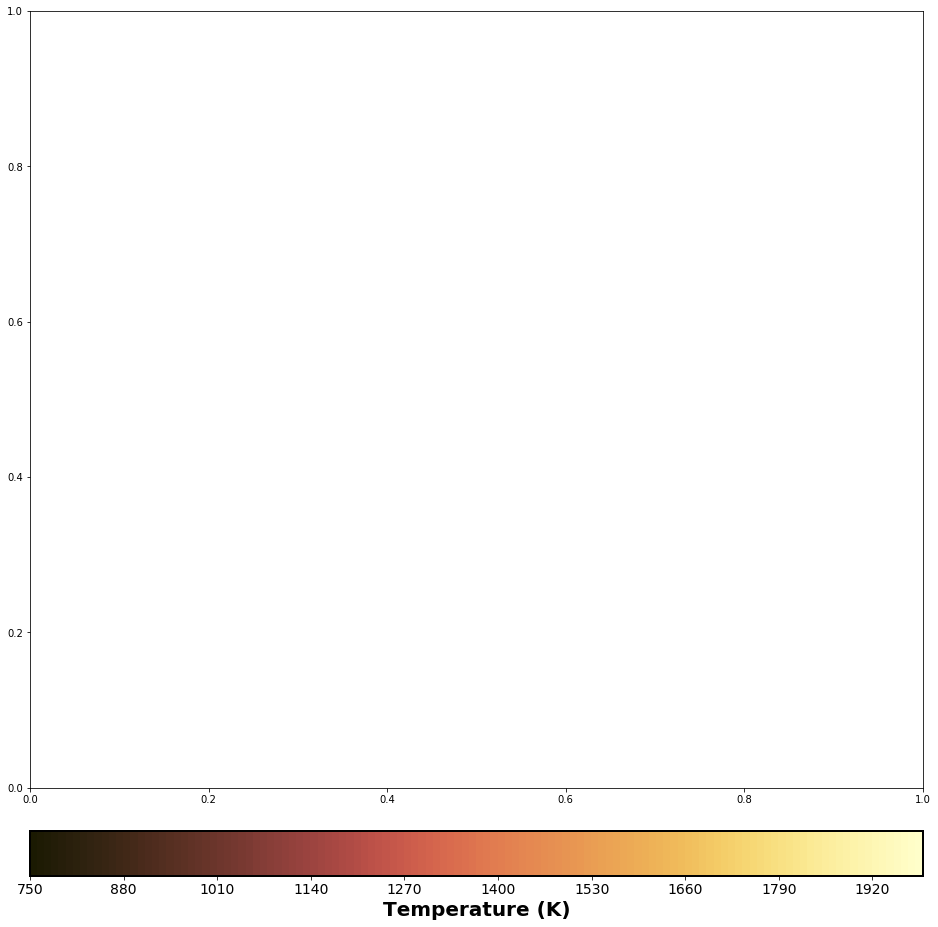

In [24]:
fig, ax = plt.subplots(1, figsize=(16, 16))

cbar = plt.colorbar(cs1, orientation='horizontal', fraction=.057, pad=0.05, aspect=20)
cbar.outline.set_linewidth(2)
cbar.set_label(label='Temperature (K)',weight='bold', fontsize=20)
cbar.ax.tick_params(labelsize=14) 
cbar.ax.set_yticklabels(fontsize=16, weight='bold')


plt.savefig('/home/imalsky/Desktop/sidebar.png', bbox_inches='tight', dpi=250)
